In [1]:
import time
import os
import logging

from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import numpy as np
import itertools
import pickle
import pandas as pd

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from pypalettes import get_hex

# torch packages
import torch
import torch.optim as optim
import torch.nn as nn

from torch.nn.functional import mse_loss, l1_loss
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import v2
#from torchvision.utils import make_grid
from torchsummary import summary

#import torch.nn.functional as F

FILENAME = 'STATS_Autoenc_SIC_'

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from autoenc_highres import Encoder_sharp, Decoder_sharp, Encoder_sharp_1024, Decoder_sharp_1024
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, test_data_stats, thousands,millions, multiple_dfs_to_excel

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

formatter = FuncFormatter(thousands)
formatter_mil = FuncFormatter(millions)

In [2]:
"""Directories"""

pkl_dir = r'../outputs/pkl/'
stats_dir = r'../outputs/stats/'
import_dir = r'../inputs/'


In [3]:
#seed for repeatable results
torch.manual_seed(0)
gen1 = torch.Generator().manual_seed(0)

run_sharp = True

clamp_yn = True
norm_yn = False

In [4]:
sic_data, m , x,y,Y_mean_month, Y_mean_week = get_ice_data(return_all = True)

In [5]:
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 32 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 210  #215 #batch size for dataloader will vary PC to PC
dim_latent = 64 #2,4,8,16,24,32,
T_test = 365*2

train_split = int(num_year_data*0.8) * 365
val_split = num_year_data *365 - train_split

X0_ = get_days_before(sic_data, year, day, T_train+window-1) # get days from DATA
X1_ = get_days_after(sic_data, year, day,T_test)

# if window > 1:
#     X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
#     X1_ = get_test_set(sic_data, year, day, window, T_test)
# X0_.shape, X1_.shape

# X0_ = get_days_before(sic_data, year, day, T_train+window-1)
# X1_ = get_days_after(sic_data, year, day,  365*2)

In [6]:
file_img_bopdmd = r'C:/Project/01UCL_MSC_Project_LFS/bopdmd_SIC_win_1_history_5_SVD_5.pkl'
file_img_dldmd = import_dir + 'dldmd/images/seq_dldmd_SIC_win_1_history_2_SVD_5.pkl'
file_img_redldmd = import_dir+'dldmd/images/retrained_seq_dldmd_SIC_win_1_history_2_SVD_5.pkl'
file_img_lstm = import_dir + 'lstm/images/lstm_SIC_win_1.pkl'
file_img_latent_avg = import_dir + 'lstm/images/c_latent_avg_lstm_SIC_win_20.pkl'
file_img_img_avg = import_dir + 'lstm/images/c_img_avg_lstm_SIC_win_20.pkl'

file_img_cavgimg = r'C:/Project/01UCL_MSC_Project_LFS/c_img_avg_climate_SIC_win_20.pkl'
file_img_cavglatent = import_dir + 'lstm/images/c_latent_avg_climate_SIC_win_20.pkl'

In [7]:
with open(file_img_bopdmd, "rb") as in_data:
    img_bopdmd = pickle.load(in_data)

with open(file_img_dldmd, "rb") as in_data:
    img_dldmd = pickle.load(in_data)

with open(file_img_redldmd, "rb") as in_data:
    img_redldmd = pickle.load(in_data)

with open(file_img_lstm, "rb") as in_data:
    img_lstm = pickle.load(in_data)

########################################################
with open(file_img_latent_avg, "rb") as in_data:
    img_latent_avg = pickle.load(in_data)

with open(file_img_img_avg, "rb") as in_data:
    img_img_avg = pickle.load(in_data)

with open(file_img_cavgimg, "rb") as in_data:
    img_cavgimg = pickle.load(in_data)

with open(file_img_cavglatent, "rb") as in_data:
    img_cavglatent = pickle.load(in_data)

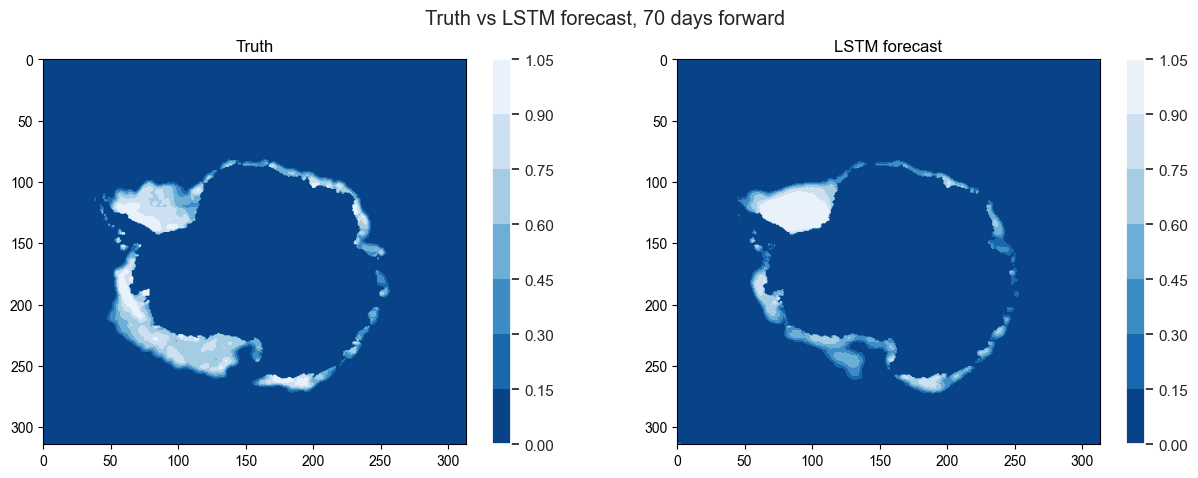

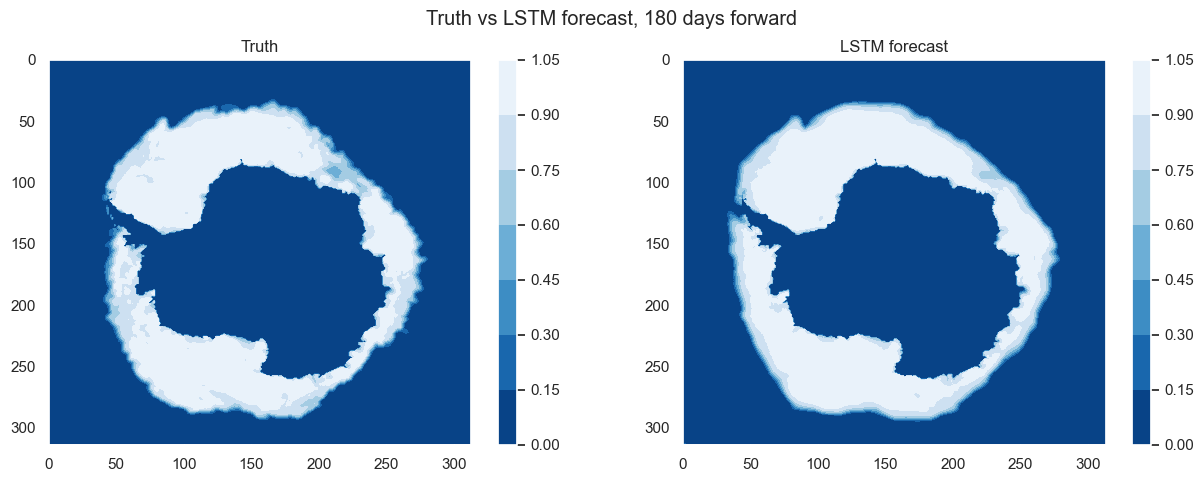

In [8]:
import seaborn as sns

pred_imgs = img_lstm

fig_1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.set(style="darkgrid")
sns.color_palette("crest", as_cmap=True)
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax_1 = ax1.contourf(X1_[71], cmap=plt.get_cmap('Blues_r'))
ax1.set_title("Truth")
ax1.set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_2 = ax2.contourf(pred_imgs[71], cmap=plt.get_cmap('Blues_r'))
ax2.set_title("LSTM forecast")
ax2.set_ylim(314, 0)
cbar2 = fig_1.colorbar(ax_2)

fig_1.suptitle("Truth vs LSTM forecast, 70 days forward")
plt.show()

#########################################################
fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(15,5))

sns.color_palette("crest", as_cmap=True)
sns.set(style="darkgrid")
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax_3 = ax3.contourf(X1_[179], cmap=plt.get_cmap('Blues_r'))
ax3.set_title("Truth")
ax3.set_ylim(314, 0)
cbar3 = fig_2.colorbar(ax_3)

ax_4 = ax4.contourf(pred_imgs[179], cmap=plt.get_cmap('Blues_r'))
ax4.set_title("LSTM forecast")
ax4.set_ylim(314, 0)
cbar4 = fig_2.colorbar(ax_4)

fig_2.suptitle("Truth vs LSTM forecast, 180 days forward")
plt.show()

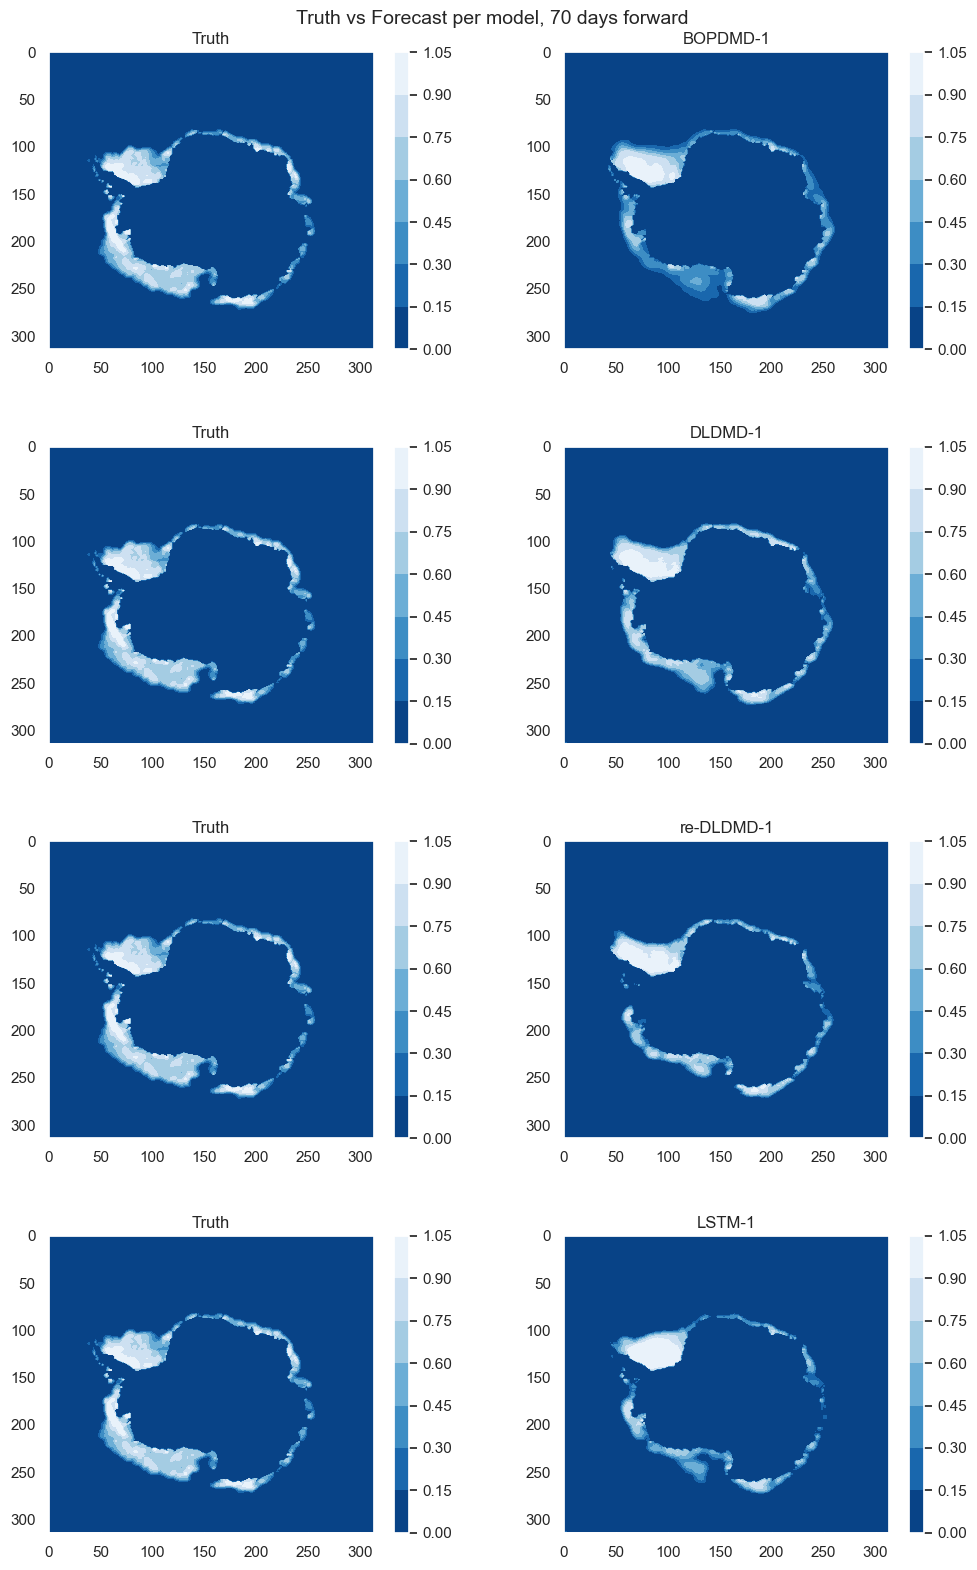

In [28]:
import seaborn as sns

img_idx = 71
#img_idx = 179

if img_idx == 71:
    img_num = 70
else:
    img_num = 180

fig_1, axs = plt.subplots(4,2, figsize=(10,16))

sns.set(style="darkgrid")
sns.color_palette("crest", as_cmap=True)
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax_1 = axs[0][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[0][0].set_title("Truth")
axs[0][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[1][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[1][0].set_title("Truth")
axs[1][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[2][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[2][0].set_title("Truth")
axs[2][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[3][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[3][0].set_title("Truth")
axs[3][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

#####################################################################

ax_1 = axs[0][1].contourf(img_bopdmd[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[0][1].set_title("BOPDMD-1")
axs[0][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[1][1].contourf(img_dldmd[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[1][1].set_title("DLDMD-1")
axs[1][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[2][1].contourf(img_redldmd[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[2][1].set_title("re-DLDMD-1")
axs[2][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[3][1].contourf(img_lstm[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[3][1].set_title("LSTM-1")
axs[3][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

fig_1.suptitle("Truth vs Forecast per model, {} days forward".format(img_num), size = 14)
plt.tight_layout(h_pad=3, w_pad = 4)

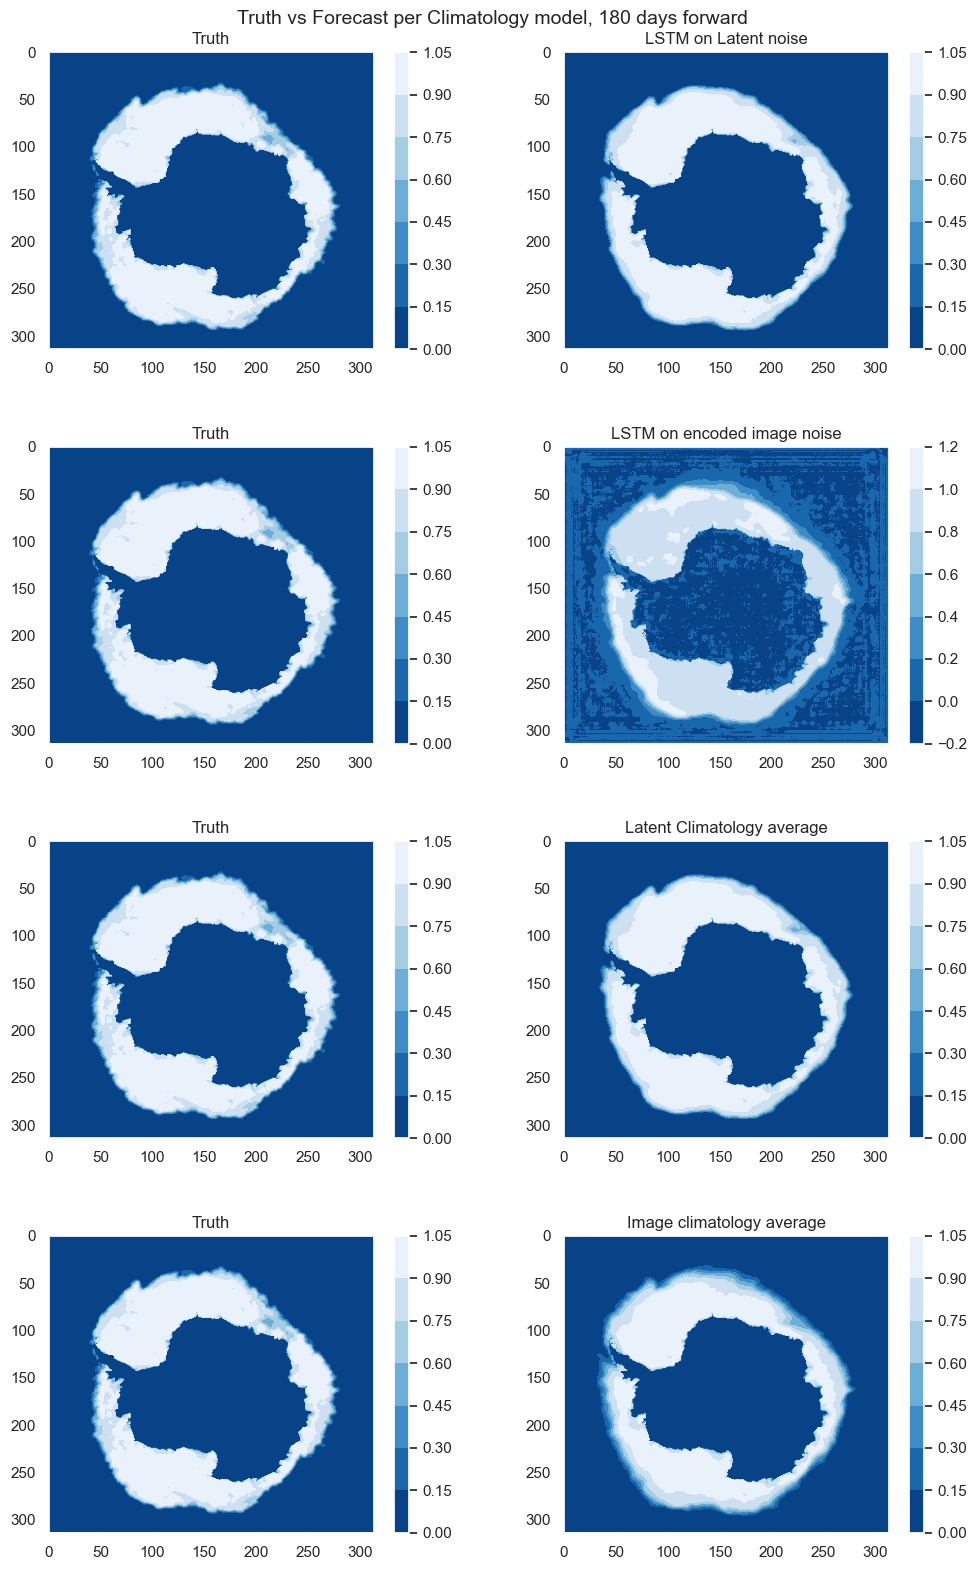

In [26]:
import seaborn as sns

#img_idx = 71
img_idx = 179

if img_idx == 71:
    img_num = 70
else:
    img_num = 180


fig_1, axs = plt.subplots(4,2, figsize=(10,16))

sns.set(style="darkgrid")
sns.color_palette("crest", as_cmap=True)
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax_1 = axs[0][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[0][0].set_title("Truth")
axs[0][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[1][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[1][0].set_title("Truth")
axs[1][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[2][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[2][0].set_title("Truth")
axs[2][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[3][0].contourf(X1_[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[3][0].set_title("Truth")
axs[3][0].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

#####################################################################

ax_1 = axs[0][1].contourf(img_latent_avg[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[0][1].set_title("LSTM on Latent noise")
axs[0][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[1][1].contourf(img_img_avg[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[1][1].set_title("LSTM on encoded image noise")
axs[1][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[2][1].contourf(img_cavglatent[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[2][1].set_title("Latent Climatology average")
axs[2][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_1 = axs[3][1].contourf(img_cavgimg[img_idx], cmap=plt.get_cmap('Blues_r'))
axs[3][1].set_title("Image climatology average")
axs[3][1].set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

fig_1.suptitle("Truth vs Forecast per Climatology model, {} days forward".format(img_num), size = 14)
plt.tight_layout(h_pad=3, w_pad = 4)

In [11]:

# ax2 = axs[0][0].twinx()
# sns.lineplot(data=melted_dfs[1], x='pred_day', y = 'IIEE',color="r", ax=ax2, label ='IIEE')
# ax2.yaxis.set_major_formatter(formatter_mil)
# ax2.grid(False)
# ax2.set(ylabel='IIEE, km sq')
# ax2.set_ylim([1e6, 3.0e6])

# ##################################

# ax3 = sns.lineplot(melted_dfs[2], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[0][1] )
# ax3.grid(False)
# ax3.set(xlabel='Forecast day')
# ax3.set_ylim([0.016, 0.042])
# ax3.title.set_text(title_list[1])

# ax4 = axs[0][1].twinx()
# sns.lineplot(data=melted_dfs[3], x='pred_day', y = 'IIEE',color="r", ax=ax4, label ='_IIEE')
# ax4.yaxis.set_major_formatter(formatter_mil)
# ax4.grid(False)
# ax4.set(ylabel='IIEE, km sq')
# ax4.set_ylim([1e6, 3.0e6])

# ################################################
# ax5 = sns.lineplot(melted_dfs[4], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][0] )
# ax5.grid(False)
# ax5.set(xlabel='Forecast day')
# ax5.set_ylim([0.016, 0.042])
# ax5.title.set_text(title_list[2])

# ax6 = axs[1][0].twinx()
# sns.lineplot(data=melted_dfs[5], x='pred_day', y = 'IIEE',color="r", ax=ax6, label ='_IIEE')
# ax6.yaxis.set_major_formatter(formatter_mil)
# ax6.grid(False)
# ax6.set(ylabel='IIEE, km sq')
# ax6.set_ylim([1e6, 3.0e6])

# ####################################################

# ax7 = sns.lineplot(melted_dfs[6], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][1] )
# ax7.grid(False)
# ax7.set(xlabel='Forecast day')
# ax7.set_ylim([0.016, 0.042])
# ax7.title.set_text(title_list[3])


# ax8 = axs[1][1].twinx()
# sns.lineplot(data=melted_dfs[7], x='pred_day', y = 'IIEE',color="r", ax=ax8, label ='_IIEE')
# ax8.yaxis.set_major_formatter(formatter_mil)
# ax8.grid(False)
# ax8.set(ylabel='IIEE, km sq')
# ax8.set_ylim([1e6, 3.0e6])

# #ax8.legend(loc = 'lower right')

# #handles, labels = plt.gca().get_legend_handles_labels()

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig.legend(lines, labels, loc="lower right", ncol=2)

# #fig.subplots_adjust(hspace=0.1)
# fig.suptitle("Sequential DLDMD - SIC forecast error per image", size = 20, y=1)

# axis_list = [ax1,ax2]

# for i in axis_list: i.get_legend().remove()

# #ax8.get_legend().remove()
# #plt.show()
# plt.tight_layout(h_pad=3, w_pad = 3)


In [12]:
# with open(pkl_dir + 'seq_dldmd_pred.pkl', 'wb') as output:
#     pickle.dump(pred_dec.numpy()[:180], output)
#     #del latent_train

In [13]:
#import seaborn as sns

In [14]:
# """plots using  window = 1, history = 2, svd = 5"""

# fig_1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

# sns.color_palette("crest", as_cmap=True)
# palette = get_hex("Aluterus_scriptus", keep_first_n=5)

# ax_1 = ax1.contourf(X1_[70], cmap=plt.get_cmap('Blues_r'))
# ax1.set_title("Truth")
# ax1.set_ylim(314, 0)
# cbar1 = fig_1.colorbar(ax_1)

# ax_2 = ax2.contourf(pred_dec.numpy()[70], cmap=plt.get_cmap('Blues_r'))
# ax2.set_title("Sequential DLDMD forecast")
# ax2.set_ylim(314, 0)
# cbar2 = fig_1.colorbar(ax_2)

# sns.set(style="darkgrid")

# fig_1.suptitle("Truth vs Sequential DLDMD forecast, 70 days forward")
# plt.show()

In [15]:
# fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(15,5))

# ax_3 = ax3.contourf(X1_[179], cmap=plt.get_cmap('Blues_r'))
# ax3.set_title("Truth")
# ax3.set_ylim(314, 0)
# cbar3 = fig_2.colorbar(ax_3)

# ax_4 = ax4.contourf(pred_dec.numpy()[179], cmap=plt.get_cmap('Blues_r'))
# ax4.set_title("Sequential DLDMD forecast")
# ax4.set_ylim(314, 0)
# cbar4 = fig_2.colorbar(ax_4)

# sns.set(style="darkgrid")

# fig_2.suptitle("Truth vs Sequential DLDMD forecast, 180 days forward")
# plt.show()

In [16]:
# def melt_frame_lineplot_any(input_mae,metric, qry):
#     temp_df = input_mae.query(qry)

#     temp_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )
#     temp_df['pred_day'] = temp_df['pred_day']-2

#     return temp_df

In [17]:
# melted_int_dfs = []
# title_int_list = []

# for i in best_win_his:
#     m,n,o = i
#     input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)

#     out_df1 = melt_frame_lineplot_any(dmd_true_integral_df,"True" , input_qry)
#     out_df2 = melt_frame_lineplot_any(dmd_pred_integral_df,"Pred" , input_qry)
#     melted_int_dfs.append(out_df1)
#     melted_int_dfs.append(out_df2)
    
#     if m == 1:
#         temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
#     else:
#         temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
#     title_int_list.append(temp_title)

In [18]:
# import seaborn as sns

# sns.set(style="whitegrid")
# fig_int, axs_int = plt.subplots(2, 2, figsize=(15, 8))

# ax1_int = sns.lineplot(melted_int_dfs[0], x='pred_day', y = 'True', label ='True', ax =axs_int[0][0], color="b" )
# sns.lineplot(data=melted_int_dfs[1], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][0], label ='Pred')
# ax1_int.grid(False)
# ax1_int.set(xlabel='Forecast day')
# ax1_int.title.set_text(title_int_list[0])
# ax1_int.set_ylim([0.0, 0.25])
# ax1_int.set(ylabel="Total Ice")

# ax2_int = sns.lineplot(melted_int_dfs[2], x='pred_day', y = 'True', label ='_True', ax =axs_int[0][1], color="b" )
# sns.lineplot(data=melted_int_dfs[3], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][1], label ='_Pred')
# ax2_int.grid(False)
# ax2_int.set(xlabel='Forecast day')
# ax2_int.title.set_text(title_int_list[1])
# ax2_int.set_ylim([0.0, 0.25])
# ax2_int.set(ylabel="Total Ice")

# ax3_int = sns.lineplot(melted_int_dfs[4], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][0], color="b" )
# sns.lineplot(data=melted_int_dfs[5], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][0], label ='_Pred')
# ax3_int.grid(False)
# ax3_int.set(xlabel='Forecast day')
# ax3_int.title.set_text(title_int_list[2])
# ax3_int.set_ylim([0.0, 0.25])
# ax3_int.set(ylabel="Total Ice")


# ax4_int = sns.lineplot(melted_int_dfs[6], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][1], color="b" )
# sns.lineplot(data=melted_int_dfs[7], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][1], label ='_Pred')
# ax4_int.grid(False)
# ax4_int.set(xlabel='Forecast day')
# ax4_int.title.set_text(title_int_list[3])
# ax4_int.set_ylim([0.0, 0.25])
# ax4_int.set(ylabel="Total Ice")


# lines_labels = [ax.get_legend_handles_labels() for ax in fig_int.axes]

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig_int.legend(lines, labels, loc="lower right", ncol=2)

# #fig.subplots_adjust(hspace=0.1)
# fig_int.suptitle("Sequential DLDMD - Total Ice per forecasted day", size = 20, y=1)

# axis_list = [ax1_int]

# for i in axis_list: i.get_legend().remove()

# #ax8.get_legend().remove()
# #plt.show()
# plt.tight_layout(h_pad=3, w_pad = 3)


In [19]:
# melted_latent_dfs = []
# title_latent_list = []

# for i in best_win_his:
#     m,n,o = i
#     #input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)
#     for idx, j in enumerate(latent_space_pred):
#         if j[0] == i:
#             melted_latent_dfs.append(j[1])
#             melted_latent_dfs.append(latent_space_true[idx][1])
        
#             if m == 1:
#                 temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
#             else:
#                 temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
#             title_latent_list.append(temp_title)



In [20]:
# import seaborn as sns


# latent_idx = 0
# sns.set(style="whitegrid")
# fig_lat, axs_lat = plt.subplots(2, 2, figsize=(15, 8), constrained_layout=False)

# axs_lat[0][0].plot(melted_latent_dfs[0][:,latent_idx], label="pred latent idx = 0", color='green')
# axs_lat[0][0].plot(melted_latent_dfs[1][:,latent_idx], label="true latent idx = 0", color='orange')

# # axs_lat[0][0].plot(melted_latent_dfs[0][:,2])
# # axs_lat[0][0].plot(melted_latent_dfs[1][:,2])
# axs_lat[0][0].set_xlim(0, 180)
# axs_lat[0][0].set_ylim(0.4, 0.8)
# axs_lat[0][0].set_xlabel('Forecast day')
# axs_lat[0][0].set_ylabel('Latent value')
# axs_lat[0][0].set_title(title_latent_list[0])

# axs_lat[0][1].plot(melted_latent_dfs[2][:,latent_idx], label="_pred latent idx = 0",color='green')
# axs_lat[0][1].plot(melted_latent_dfs[3][:,latent_idx], label="_true latent idx = 0",color='orange')
# axs_lat[0][1].set_xlim(0, 180)
# axs_lat[0][1].set_ylim(0.4, 0.8)
# axs_lat[0][1].set_xlabel('Forecast day')
# axs_lat[0][1].set_ylabel('Latent value')
# axs_lat[0][1].set_title(title_latent_list[1])

# axs_lat[1][0].plot(melted_latent_dfs[4][:,latent_idx], label="_pred latent idx = 0",color='green')
# axs_lat[1][0].plot(melted_latent_dfs[5][:,latent_idx], label="_true latent idx = 0",color='orange')
# axs_lat[1][0].set_xlim(0, 180)
# axs_lat[1][0].set_ylim(0.4, 0.8)
# axs_lat[1][0].set_xlabel('Forecast day')
# axs_lat[1][0].set_ylabel('Latent value')
# axs_lat[1][0].set_title(title_latent_list[2])

# axs_lat[1][1].plot(melted_latent_dfs[6][:,latent_idx], label="_pred latent idx = 0",color='green')
# axs_lat[1][1].plot(melted_latent_dfs[7][:,latent_idx], label="_true latent idx = 0",color='orange')
# axs_lat[1][1].set_xlim(0, 180)
# axs_lat[1][1].set_ylim(0.4, 0.8)
# axs_lat[1][1].set_xlabel('Forecast day')
# axs_lat[1][1].set_ylabel('Latent value')
# axs_lat[1][1].set_title(title_latent_list[3])

# fig_lat.suptitle("Sequential DLDMD - latent space", size = 20, y=1)

# lines_labels = [ax.get_legend_handles_labels() for ax in fig_lat.axes]

# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig_lat.legend(lines, labels, loc="lower center", ncol=2)

# plt.tight_layout(h_pad=3, w_pad = 3)

In [21]:
# with open(r'../outputs/seq_dmd_stats/all_seqdmd_stats_' + time.strftime("%Y%m%d"), 'wb') as output:
#      pickle.dump([dmd_avg_stat_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df,dmd_latent_recon_df, dmd_latent_fwd_df], output)

In [22]:
# with open(r'../outputs/seq_dmd_stats/all_seqdmd_stats_20240815', 'rb') as f:
#     loaded_df = pickle.load(f)

# dmd_avg_stat_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df,dmd_latent_recon_df, dmd_latent_fwd_df = loaded_df

In [23]:
# dmd_avg_stat_df.to_csv(stats_dir + "Seq_DMD_avg_stat_df.csv")

# dmd_latent_recon_df.to_csv(stats_dir + "Seq_DMD_latentrecon_stat_df.csv")
# dmd_latent_fwd_df.to_csv(stats_dir + "Seq_DMD_avg_latentfwd_df.csv")

In [24]:
# import seaborn as sns

# def query_boxplot(qry, metric, input_df, plt_title,shade = "BluetoGray_8", yxformat = None):
    
#     temp_df = input_df.query(qry)
#     melt_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )

#     fig, axs = plt.subplots(1, 1, figsize=(16, 7))

#     #palette = get_hex("Bmlunge")
#     sns.set_theme()
#     palette = get_hex(shade, keep_first_n=8)
#     sns.set_style("darkgrid")
#     ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
#     #ax_sns.set_title("Distribution of IIEE  - Forecasted SIC images")
#     ax_sns.set_title(plt_title)

#     if yxformat is not None:
#         ax_sns.yaxis.set_major_formatter(yxformat)

#     l = ax_sns.legend(title= 'History:', bbox_to_anchor=(0.2, -0.07), ncol = 5, loc = 'center', frameon=False)
#     #sns.move_legend(ax_sns, "center", bbox_to_anchor=(0.5, -0.15), ncol = 5, frameon=False)
#     l.get_title().set_position((-190, -21))

#     #sns.set_style()
#     plt.plot()

In [25]:
# win = 1
# svd_u = 11
# svd_l = 2

# input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(win, svd_u, svd_l)

# query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images" )
# query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images", yxformat = formatter)

# for i in [5,10,20]:
#     input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(i, svd_u, svd_l)
#     query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images, {}-day Moving averge".format(i) )
#     query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images, {}-day Moving averge".format(i), yxformat = formatter)